## Importing needed libraries

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision.utils import make_grid

## using GPU

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST Dataset loading

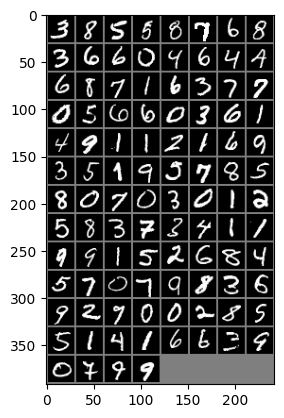

sample Labels: 3 8 5 5 8 7 6 8 3 6 6 0 4 6 4 4 6 8 7 1 6 3 7 7 0 5 6 6 0 3 6 1


In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

batch_size = 128
train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(data_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print('sample Labels:', ' '.join(f'{labels[j].item()}' for j in range(32)))


## Discriminator model

In [29]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

## Generator model

In [30]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.fc(x)

## Initializing models, loss and optimiztion

In [31]:
latent_size = 100
image_size = 28 * 28
G = Generator(latent_size, image_size).to(device)
D = Discriminator(image_size).to(device)

loss_fn = nn.BCELoss()
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

## Training

In [32]:
def train_GAN(num_epochs, print_interval=5):
    for epoch in range(1, num_epochs + 1):
        for real_images, _ in train_loader:
            batch_size = real_images.size(0)

            # Flatten images
            real_images = real_images.view(batch_size, -1).to(device)

            # Create real and fake labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # ===== Train Discriminator =====
            outputs = D(real_images)
            D_real_loss = loss_fn(outputs, real_labels)

            # Generate fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)


            outputs = D(fake_images.detach())
            D_fake_loss = loss_fn(outputs, fake_labels)


            D_loss = D_real_loss + D_fake_loss

            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

            # ===== Train Generator =====
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)

            # Generator loss (try to fool the discriminator)
            outputs = D(fake_images)
            G_loss = loss_fn(outputs, real_labels)  # We want the discriminator to label the fake images as real
            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()

        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")
        if epoch % print_interval == 0:
            show_generated_images(G, epoch)

def show_generated_images(G, epoch):
    with torch.no_grad():
        z = torch.randn(64, latent_size).to(device)
        fake_images = G(z).view(-1, 1, 28, 28).cpu()
        grid = make_grid(fake_images, nrow=8, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).detach().numpy(), cmap="gray")
        plt.title(f"Epoch {epoch}")
        plt.show()


Epoch [1/50] | D Loss: 0.2032 | G Loss: 7.0063
Epoch [2/50] | D Loss: 3.1244 | G Loss: 0.6315
Epoch [3/50] | D Loss: 2.1587 | G Loss: 0.7322
Epoch [4/50] | D Loss: 2.0317 | G Loss: 1.1733
Epoch [5/50] | D Loss: 0.8243 | G Loss: 1.4790


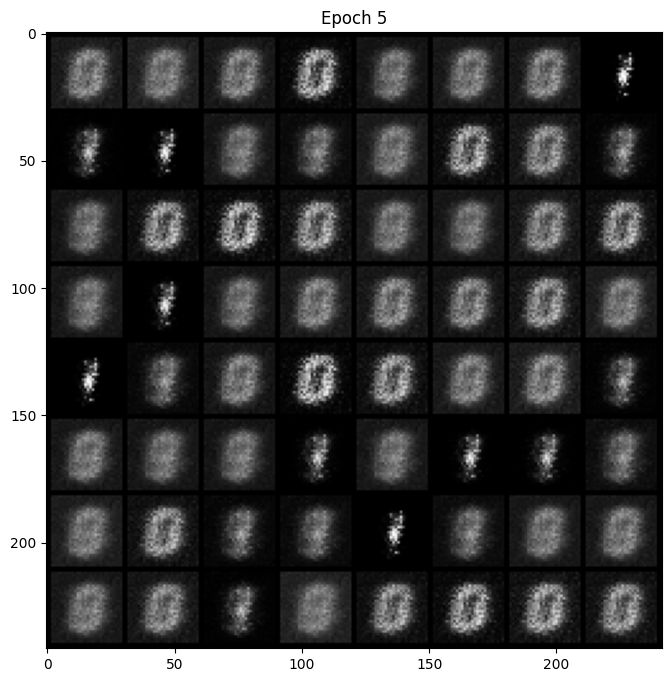

Epoch [6/50] | D Loss: 0.4312 | G Loss: 2.6825
Epoch [7/50] | D Loss: 0.5552 | G Loss: 2.5030
Epoch [8/50] | D Loss: 0.7334 | G Loss: 3.9456
Epoch [9/50] | D Loss: 0.4287 | G Loss: 2.2690
Epoch [10/50] | D Loss: 0.3821 | G Loss: 3.5012


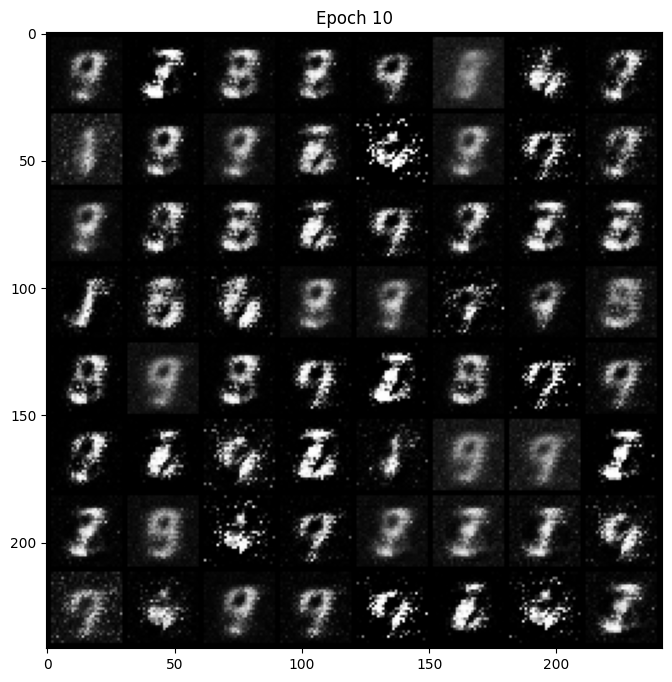

Epoch [11/50] | D Loss: 0.6418 | G Loss: 3.2732
Epoch [12/50] | D Loss: 0.4951 | G Loss: 2.6115
Epoch [13/50] | D Loss: 0.5346 | G Loss: 3.0009
Epoch [14/50] | D Loss: 0.6709 | G Loss: 2.4584
Epoch [15/50] | D Loss: 0.8188 | G Loss: 2.2766


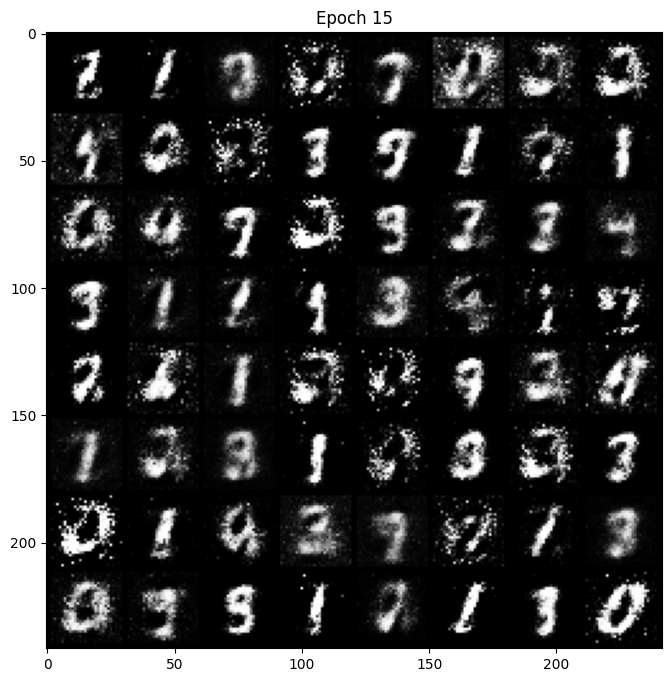

Epoch [16/50] | D Loss: 0.7957 | G Loss: 2.3130
Epoch [17/50] | D Loss: 0.9921 | G Loss: 1.7538
Epoch [18/50] | D Loss: 0.7261 | G Loss: 2.1051
Epoch [19/50] | D Loss: 0.6082 | G Loss: 2.0548
Epoch [20/50] | D Loss: 0.6426 | G Loss: 2.0795


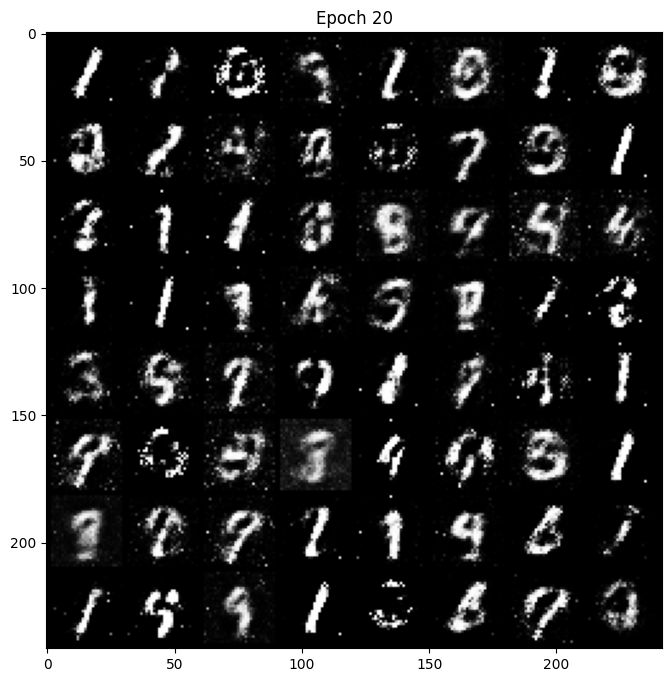

Epoch [21/50] | D Loss: 0.8455 | G Loss: 2.6506
Epoch [22/50] | D Loss: 0.6268 | G Loss: 1.7930
Epoch [23/50] | D Loss: 0.7716 | G Loss: 1.8332
Epoch [24/50] | D Loss: 0.7351 | G Loss: 1.8939
Epoch [25/50] | D Loss: 0.7901 | G Loss: 1.7024


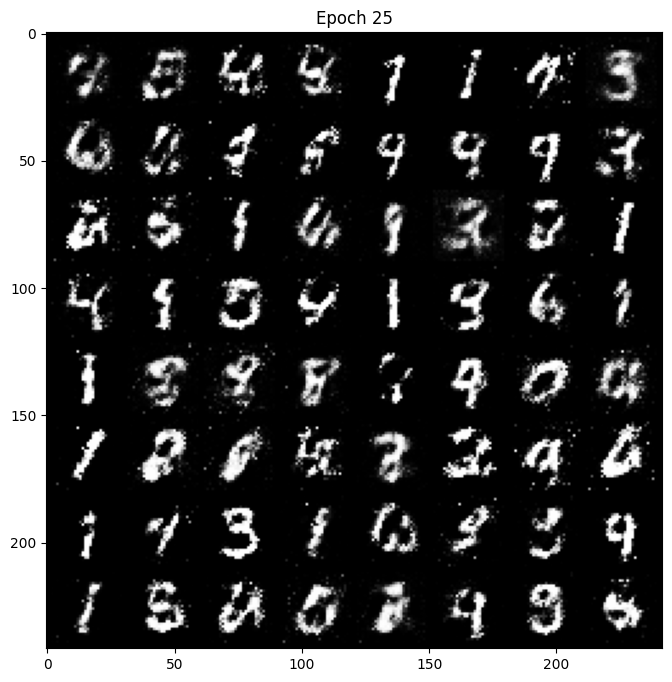

Epoch [26/50] | D Loss: 0.8454 | G Loss: 1.9266
Epoch [27/50] | D Loss: 0.8573 | G Loss: 2.1830
Epoch [28/50] | D Loss: 0.8383 | G Loss: 1.5071
Epoch [29/50] | D Loss: 0.8924 | G Loss: 1.8514
Epoch [30/50] | D Loss: 0.9666 | G Loss: 1.5285


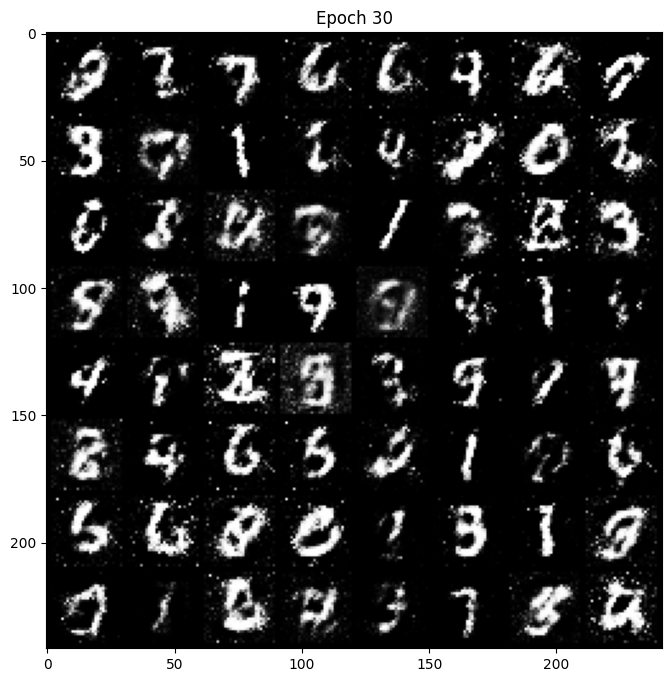

Epoch [31/50] | D Loss: 0.8420 | G Loss: 1.8902
Epoch [32/50] | D Loss: 0.8167 | G Loss: 1.5956
Epoch [33/50] | D Loss: 0.9182 | G Loss: 1.3235
Epoch [34/50] | D Loss: 1.1748 | G Loss: 1.2125
Epoch [35/50] | D Loss: 0.9683 | G Loss: 1.6636


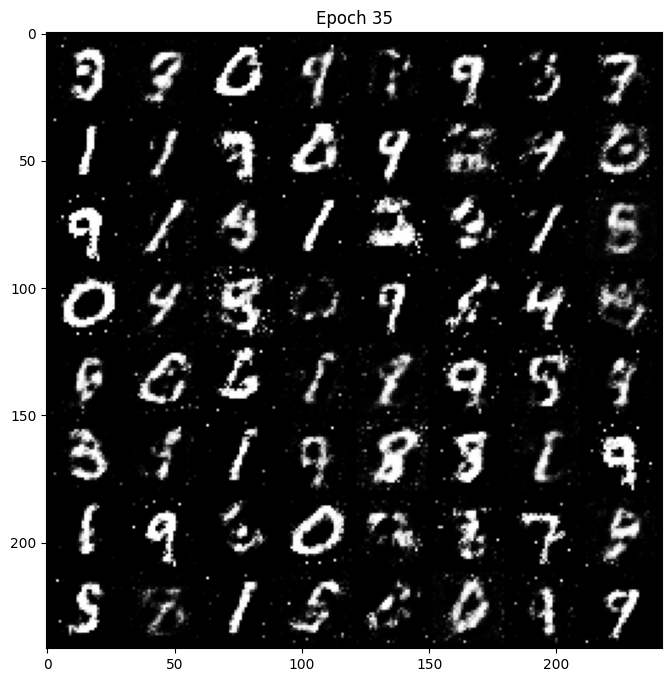

Epoch [36/50] | D Loss: 1.1726 | G Loss: 1.4705
Epoch [37/50] | D Loss: 1.0662 | G Loss: 1.1886
Epoch [38/50] | D Loss: 0.9350 | G Loss: 1.4273
Epoch [39/50] | D Loss: 1.0127 | G Loss: 1.4967
Epoch [40/50] | D Loss: 0.9448 | G Loss: 1.0762


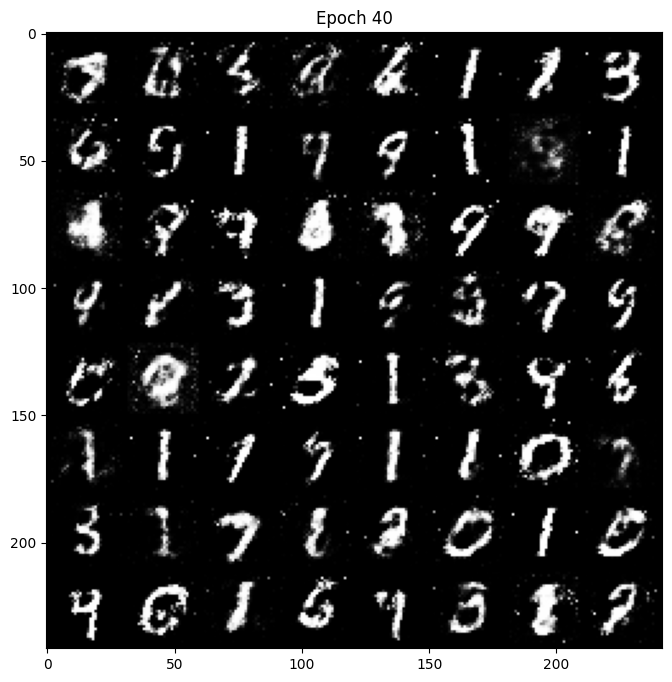

Epoch [41/50] | D Loss: 1.2765 | G Loss: 1.5360
Epoch [42/50] | D Loss: 0.9621 | G Loss: 1.2781
Epoch [43/50] | D Loss: 1.0802 | G Loss: 1.1659
Epoch [44/50] | D Loss: 1.1387 | G Loss: 1.4049
Epoch [45/50] | D Loss: 0.9740 | G Loss: 1.3247


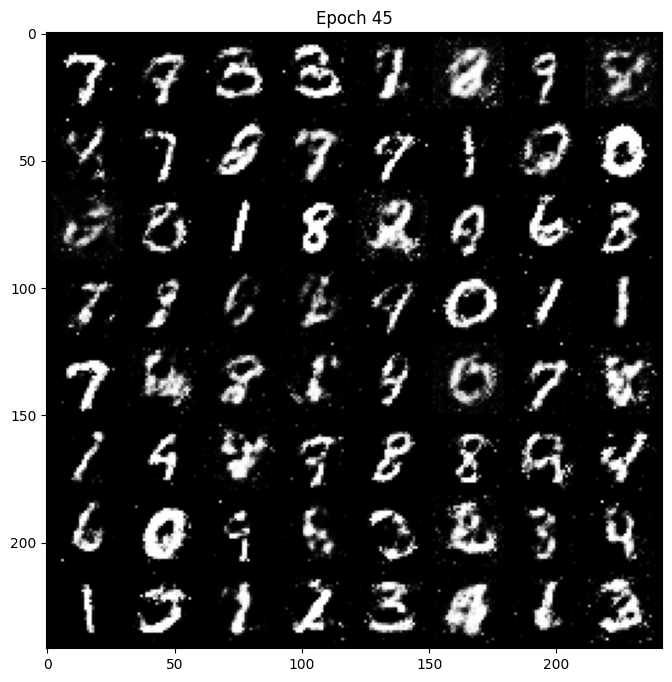

Epoch [46/50] | D Loss: 0.9336 | G Loss: 1.3946
Epoch [47/50] | D Loss: 0.8849 | G Loss: 1.3627
Epoch [48/50] | D Loss: 1.0358 | G Loss: 1.2340
Epoch [49/50] | D Loss: 1.0263 | G Loss: 1.3130
Epoch [50/50] | D Loss: 0.9685 | G Loss: 1.4570


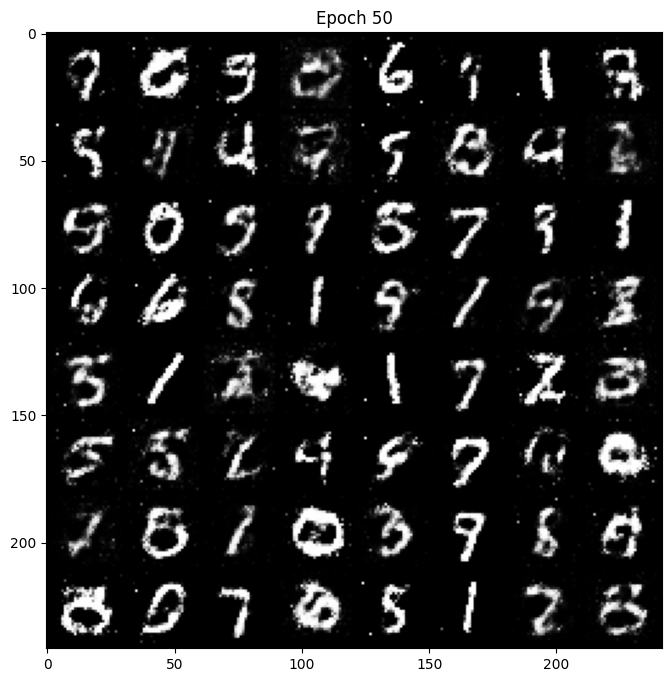

In [33]:
train_GAN(num_epochs=50, print_interval=5)